In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# setting the manual seed
manualSeed = 1000

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1000


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [3]:
device

device(type='cuda', index=0)

In [4]:
torch.cuda.empty_cache()

In [5]:
DATAROOT = "./gan-getting-started"
WORKERS = 2
BATCH_SIZE = 32
OUT_IMG_SIZE = 256
IN_CHANNELS = 3
OUT_CHANNELS = 3
ENCODING_SIZE = 100
GEN_FEATURE_SIZE = 64
DISC_FEATURE_SIZE = 64
NUM_EPOCHS = 100
lr = 0.0002
BETA1 = 0.5

In [6]:
transform = T.Compose([T.Resize(OUT_IMG_SIZE), T.CenterCrop(OUT_IMG_SIZE), T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.ImageFolder(root = "./gan-getting-started/train", transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

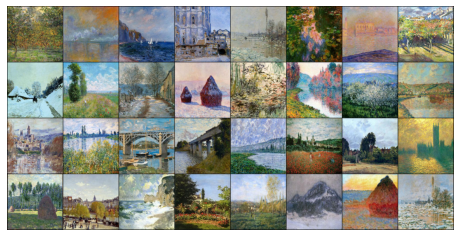

In [8]:
# displaying 1 batch of images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
# defining the generator

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is vector of size ENCODING_SIZE
            nn.ConvTranspose2d(ENCODING_SIZE, GEN_FEATURE_SIZE * 8, 16, 1, 0, bias = False),
            nn.BatchNorm2d(GEN_FEATURE_SIZE * 8),
            nn.ReLU(True),
            # (GEN_FEATURE_SIZE * 8) x 16 x 16
            nn.ConvTranspose2d(GEN_FEATURE_SIZE * 8, GEN_FEATURE_SIZE * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(GEN_FEATURE_SIZE * 4),
            nn.ReLU(True),
            # (GEN_FEATURE_SIZE * 4) x 32 x 32
            nn.ConvTranspose2d(GEN_FEATURE_SIZE * 4, GEN_FEATURE_SIZE * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(GEN_FEATURE_SIZE * 2),
            nn.ReLU(True),
            # (GEN_FEATURE_SIZE * 2) x 64 x 64
            nn.ConvTranspose2d(GEN_FEATURE_SIZE * 2, GEN_FEATURE_SIZE, 4, 2, 1, bias = False),
            nn.BatchNorm2d(GEN_FEATURE_SIZE),
            nn.ReLU(True),
            # (GEN_FEATURE_SIZE) x 128 x 128
            nn.ConvTranspose2d(GEN_FEATURE_SIZE, IN_CHANNELS, 4, 2, 1, bias = False),
            nn.Tanh()
            # (IN_CHANNELS) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)


In [11]:
generator = Generator().to(device)
generator.apply(weights_init)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(16, 16), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )


In [12]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is IN_CHANNELS x 256 x 256
            nn.Conv2d(IN_CHANNELS, DISC_FEATURE_SIZE, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            # (DISC_FEATURE_SIZE) x 128 x 128
            nn.Conv2d(DISC_FEATURE_SIZE, DISC_FEATURE_SIZE * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(DISC_FEATURE_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (DISC_FEATURE_SIZE * 2) x 64 x 64
            nn.Conv2d(DISC_FEATURE_SIZE * 2, DISC_FEATURE_SIZE * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(DISC_FEATURE_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (DISC_FEATURE_SIZE * 4) x 32 x 32
            nn.Conv2d(DISC_FEATURE_SIZE * 4, DISC_FEATURE_SIZE * 8, 4, 2, 1, bias = False),
            nn.BatchNorm2d(DISC_FEATURE_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (DISC_FEATURE_SIZE * 8) x 16 x 16|
            nn.Conv2d(DISC_FEATURE_SIZE * 8, 1, 16, 1, 0, bias = False),
            nn.Sigmoid() 
        )

    def forward(self, input):
        return self.main(input)

In [13]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(16, 16), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, ENCODING_SIZE, 1, 1, device=device)
real_label = 1.
fake_label = 0.

disc_optim = optim.Adam(discriminator.parameters(), lr = lr, betas = (BETA1, 0.999))
gen_optim = optim.Adam(generator.parameters(), lr = lr, betas = (BETA1, 0.999))

In [81]:
img_list = []
gen_losses = []
disc_losses = []
epoch = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

print("------------------------- Starting Training Loop -------------------")

while epoch < NUM_EPOCHS:
    epoch += 1
    
    for batch_idx, (data, target) in enumerate(train_loader):

        # TRAINING THE DISCRIMINATOR
        # first on real data then fake data        
        discriminator.zero_grad()

        # formatting the real data
        real_image = data.to(device)
        b_size = real_image.size(0)
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)

        # forward pass of real data through discriminator
        output = discriminator(real_image).view(-1)

        # discriminator loss on real data
        disc_real_loss = criterion(output, label)

        # calculating gradients for discriminator in backward pass
        disc_real_loss.backward()
        D_x = output.mean().item()

        # generating batch of random input vectors for Generator
        in_vec = torch.randn(b_size, ENCODING_SIZE, 1, 1, device =  device)

        # generating the fake images and labels
        fake_images = generator(in_vec)
        label.fill_(fake_label)

        # forward pass of fake data through discriminator
        output = discriminator(fake_images.detach()).view(-1)

        # discriminator loss on real data
        disc_fake_loss = criterion(output, label)

        # calculating gradients for discriminator in backward pass
        disc_fake_loss.backward()
        DG_z1 = output.mean().item()

        
        # error of discriminator
        disc_loss = disc_real_loss + disc_fake_loss

        # Update discriminator
        disc_optim.step()


        # TRAINING THE GENERATOR
        generator.zero_grad()
        
        # Expected label for each fake image generated by generator is "real_label"
        label.fill_(real_label)

        # forward pass of fake images through updated discriminator
        output = discriminator(fake_images).view(-1)

        # calculating loss for generator
        gen_loss = criterion(output, label)

        # calculating gradients for generator
        gen_loss.backward()
        DG_z2 = output.mean().item()

        # update generator
        gen_optim.step()

        if batch_idx % 10 == 0:
            print(f"epoch : {epoch/NUM_EPOCHS}\tDisc_loss : {disc_loss.item()}\tGen_loss : {gen_loss.item()}")#\tD(x) : {D_x}\tD(G(z)) : {DG_z1} / {DG_z2}")
            img_list.append(vutils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True))


        # gen_losses.append(gen_loss.item())
        # disc_losses.append(disc_loss.item())
        # del real_image
        # del data
        # del label
        # del output
        # del b_size
        # del target
        # del disc_loss
        # del gen_loss
        # del fake_images
        # del disc_fake_loss
        # del disc_real_loss
        # del in_vec

------------------------- Starting Training Loop -------------------
epoch : 0.01	Disc_loss : 0.12694573402404785	Gen_loss : 7.888159275054932
epoch : 0.02	Disc_loss : 0.9120023846626282	Gen_loss : 17.905502319335938
epoch : 0.03	Disc_loss : 0.7337275743484497	Gen_loss : 13.904350280761719
epoch : 0.04	Disc_loss : 5.7202911376953125	Gen_loss : 29.344884872436523
epoch : 0.05	Disc_loss : 0.2772504389286041	Gen_loss : 9.063806533813477
epoch : 0.06	Disc_loss : 0.15593942999839783	Gen_loss : 9.182136535644531
epoch : 0.07	Disc_loss : 0.10647742450237274	Gen_loss : 9.179929733276367
epoch : 0.08	Disc_loss : 0.2389838546514511	Gen_loss : 9.027783393859863
epoch : 0.09	Disc_loss : 0.09362781047821045	Gen_loss : 8.203167915344238
epoch : 0.1	Disc_loss : 0.14277082681655884	Gen_loss : 8.348578453063965
epoch : 0.11	Disc_loss : 0.070999875664711	Gen_loss : 7.651796817779541
epoch : 0.12	Disc_loss : 0.16305819153785706	Gen_loss : 8.216680526733398
epoch : 0.13	Disc_loss : 0.0459635928273201	Gen_

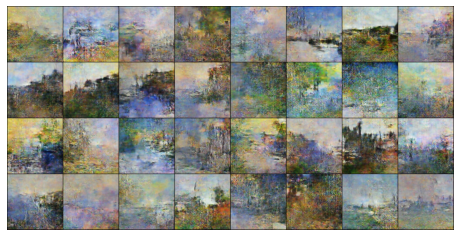

In [93]:
plt.figure(figsize=(8, 8))
plt.axis("off")
# plt.imshow(np.transpose((img_list[0][0].cpu(), (1, 2, 0))))
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

In [91]:
torch.save(generator.state_dict, "./results/generator1.pt")
torch.save(discriminator.state_dict, "./results/discriminator1.pt")

In [133]:
for i in range(100):
    in_vec = torch.randn(80, ENCODING_SIZE, 1, 1, device =  device)
    generated_images = generator(in_vec)
    j = 0 
    for image in generated_images:
        im = np.transpose(image.cpu().detach().numpy(), (1, 2, 0))
        im = (im * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(im)
        im.save(f"./generated_images/dcgan/dcgan_{i}_{j}.png")
        j+=1

In [24]:
a = torch.randn(80, 3, 256, 256)

In [25]:
a.shape

torch.Size([80, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


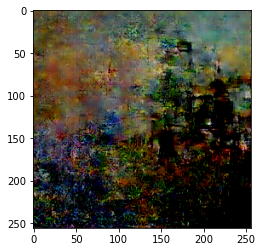

In [88]:
# inv_transform = T.Compose([T.Normalize((0., 0., 0.), (2., 2., 2.)), T.Normalize((0.5, 0.5, 0.5), (1., 1., 1.))])
# img = inv_transform(fake_images[0])
# plt.figure(figsize=(8,8))
# plt.axes("off")
plt.imshow(np.transpose(fake_images[1].cpu().detach().numpy(), (1, 2, 0)))

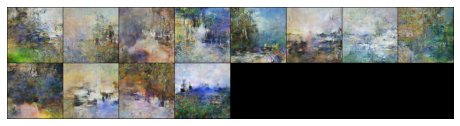

In [101]:
plt.figure(figsize=(8, 8))
plt.axis("off")
# plt.imshow(np.transpose((img_list[0][0].cpu(), (1, 2, 0))))
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


In [109]:
import PIL

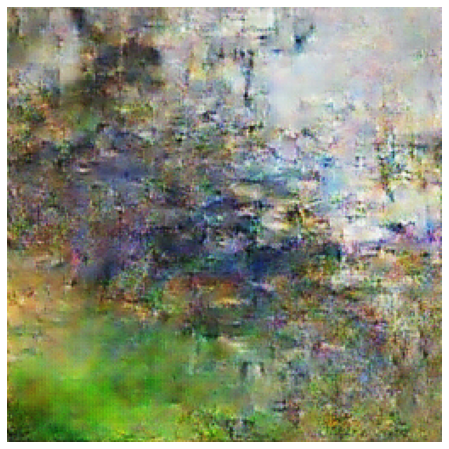

In [108]:
plt.figure(figsize=(8, 8))
plt.axis("off")
# plt.imshow(np.transpose((img_list[0][0].cpu(), (1, 2, 0))))
fig = plt.imshow(np.transpose(vutils.make_grid(fake_images[0].detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


In [129]:
im = np.transpose(fake_images[0].cpu().detach().numpy(), (1, 2, 0))
im = (im * 127.5 + 127.5).astype(np.uint8)
image = PIL.Image.fromarray(im)
image.save("sample.png")

In [121]:
im.shape

(3, 256, 256)